In [91]:
import numpy as np
import matplotlib.pyplot as plt
import wave
from playsound import playsound as play

%matplotlib inline

In [92]:
# This is the algorithm for computing DTFT of given signal
# The parameters for this Algorithm is a signal of shape (2, N) or  (N, )
# it has some default parameters like lower limit, higher limit and Number of points for omega axis

def dtft(signal, low_lim=-1*np.pi, high_lim=np.pi, N=100, endpoints=False):
    w = np.linspace(low_lim, high_lim, N, endpoint=endpoints)                  #Array of omega values
    e_jw = np.exp(w*1j)                                                    #computes e^{jw}
    
    # Creates a dictnationry to store dtft, Magnitude, Phase and omega
    dtft = dict()        
    # Creates a empty array for dtft
    dtft['complex'] = np.zeros(N, dtype=complex) 
    # Assiging omega values 
    dtft['omega'] = w
    
    # The following conditional statements are for checking whether the input(signal) is been provided with 
    # time stamps
    if signal.shape[0] == 2:
        for i in range(signal.shape[1]):
            dtft['complex'] += signal[0, i]*np.power(e_jw, -1*signal[1, i])
    else:
        for i in range(signal.shape[0]):
            dtft['complex'] += signal[i]*np.power(e_jw, -1*i)

    # Rounds-off the result upto 4 decimal places
    dtft['complex'] = np.round(dtft['complex'], decimals=4)
    # Finds the magnitude of the dtft computed above.
    dtft['magnitude'] = np.absolute(dtft['complex'])
    # Finds the phase of dtft in radians which lies in the range[-pi, pi]
    dtft['phase'] = np.angle(dtft['complex'], deg=0)
    return dtft


# This below function flips the w axis 
# Input:- X(e^jw) 
# Output:- X(e^-jw)
def negate_dtft(dtft):
    dtft['complex'] = np.flip(dtft['complex'])
    dtft['magnitude'] = np.absolute(dtft['complex'])
    dtft['phase'] = np.angle(dtft['complex'], deg=0)
    return dtft

# This below function finds the conjugate of dtft.
# Input:- X(e^jw) 
# Output:- X*(e^jw)
def conjugate(dtft):
    dtft['complex'] = np.conj(dtft['complex']) 
    dtft['phase'] = -1*dtft['phase']
    return dtft

In [93]:
# This function is used for plotting Real part, Imaginary part, Magnitude and Phase for a given DTFT

def dtft_plotter(dtft, title=None):
    plt.rcParams['figure.figsize'] = [10, 8]
    
    fig, ax = plt.subplots(2,2)
    
    if title != None:
        fig.suptitle(title, fontweight="bold")
        
    ax[0, 0].title.set_text('Real Part')
    ax[0, 0].plot(dtft['omega'], np.real(dtft['complex']))
    ax[0, 0].set(ylabel='$Re\{X(e^{j \omega})\}$')

    ax[0, 1].title.set_text('Imaginary Part')
    ax[0, 1].plot(dtft['omega'], np.imag(dtft['complex']), 'tab:red')
    ax[0, 1].yaxis.tick_right()
    ax[0, 1].set(ylabel='$Im\{X(e^{j \omega})\}$')

    ax[1, 0].title.set_text('Magnitude')
    ax[1, 0].plot(dtft['omega'], dtft['magnitude'], 'tab:orange')
    ax[1, 0].set(xlabel='$\omega$', ylabel='$|X(e^{j \omega})|$')

    ax[1, 1].title.set_text('Phase')
    ax[1, 1].plot(dtft['omega'], dtft['phase'], 'tab:green')
    ax[1, 1].yaxis.tick_right()        
    ax[1, 1].set(ylabel='$\phi$')

In [94]:
#This below function will take a file as .wav audio file as input and that verbose default parameter which will
#helpful for printing Specifications of audio file such as #frames, framerate, duration, etc.
#Output of this function will return audio signal array, time duration and Number of frames

def wavfile_to_nparray(FILE, verbose=0, time_len=None, normalise=False):
    audio_file = wave.open(FILE, 'rb')             #Opening the .wav file
    params = audio_file.getparams()                #Getting parameters of the audio file
    fr = params[2]
    if time_len != None:
        nframes = int(time_len*fr)
    else:
        nframes = params[3]
    audio_frame = audio_file.readframes(nframes)        #Reading all frames of the audio file 
    audio = np.zeros(nframes)                    #Creating an empty array for storing the values
    
    # Since the frames are3 being stores as bytes format each value will be a size of 1Byte(*bits)
    # Thus we get values ranging from 0 to 255
    # To avoid large values of dtft magnitude so we are normalizing signal from -1 to 1 
    # the audio signal to have better representation in time domain
    
    for i in range(len(audio_frame)):              
        audio[i] = audio_frame[i]                  #Storing the byte value in int array

    duration = nframes/fr                 #Time duration of the signal
    
    if normalise:
        audio = audio/2**7 - 1

    if verbose:
        print('Channels=',params[0], ', SampleWidth=', params[1],'\bbytes' 
              ,', Framerate=', fr, '\bHz', ', Frames=', nframes, '\nDuration:', time_len if time_len else 
              duration, '\bs\n')
    return audio, duration, nframes, fr

#This below function will Plot the Time signal. Computes DTFT and also plots Magnitude and phase

def analyise_wav_file(file, normalise, time_len=None):
    audio, t, frames, _ = wavfile_to_nparray(file, verbose=1, time_len=time_len, normalise=normalise)
    time = np.linspace(0, t, frames)
    
    dtft_audio = dtft(audio, N=100)
    
    plt.rcParams['figure.figsize'] = [20, 4]
    
    plt.figure()                                            #Plotting Time signal
    plt.title(file, fontsize='large', fontweight='bold')
    plt.plot(time, audio, color='green')

                                                            #Plotting Magnitude and Phase
    fig, (ax1, ax2) = plt.subplots(1,2)
    plt.suptitle("DTFT of "+file)
    ax1.title.set_text('Magnitude')
    ax1.stem(dtft_audio['omega'], dtft_audio['magnitude'])
    ax1.set(xlabel='$\omega$', ylabel='$|X(e^{j \omega})|$')

    ax2.title.set_text('Phase')
    ax2.set(xlabel='$\omega$', ylabel='$\phi$')
    ax2.stem(dtft_audio['omega'], dtft_audio['phase'], 'tab:red')

In [95]:
def fr_alter(file, fr_scale, nchannels=1, sampwidth=1):
    audio_file = wave.open(file, 'rb')
    audio_data = audio_file.readframes(-1)
    audio_fr =  audio_file.getframerate()
    audio_file.close()
    
    new_filename = file[:-4]+'_' + str(fr_scale) +'fs.wav'
    new_file = wave.open(new_filename, 'wb')

    new_file.setnchannels(nchannels)
    new_file.setsampwidth(sampwidth)
    new_file.setframerate(fr_scale*audio_fr)
    new_file.writeframesraw(audio_data)
    new_file.close()
    
    return new_filename

file = 'alarm.wav'
new_filename = fr_alter(file, 0.25)

Channels= 1 , SampleWidth= 1 bytes , Framerate= 11025 Hz , Frames= 220 
Duration: 0.02 s



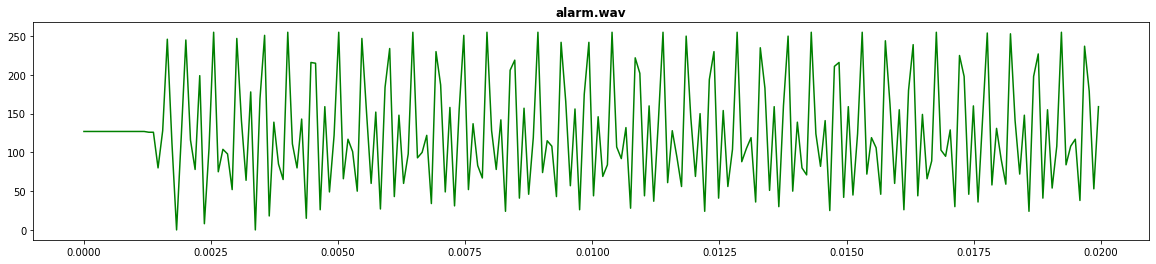

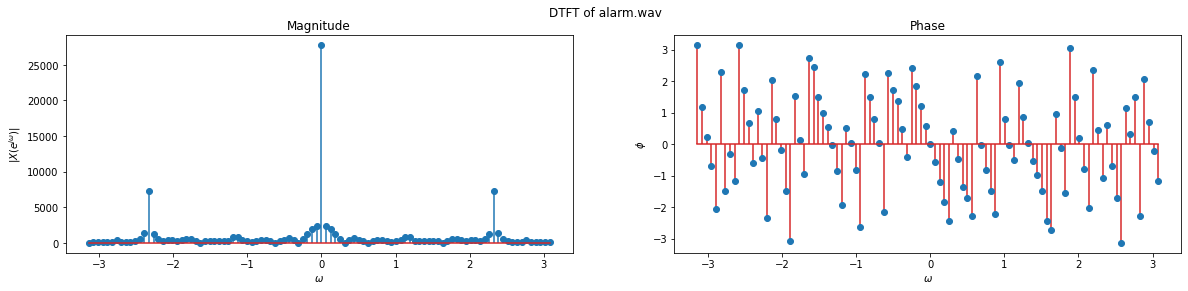

In [96]:
play(file)
analyise_wav_file(file, time_len=0.02, normalise=False)

Channels= 1 , SampleWidth= 1 bytes , Framerate= 2756 Hz , Frames= 55 
Duration: 0.02 s



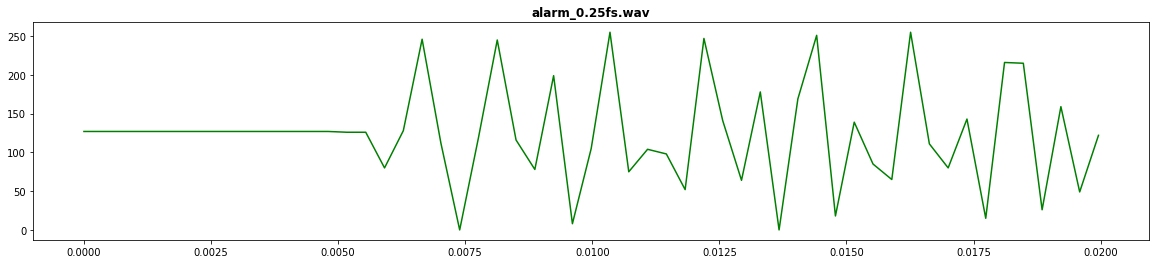

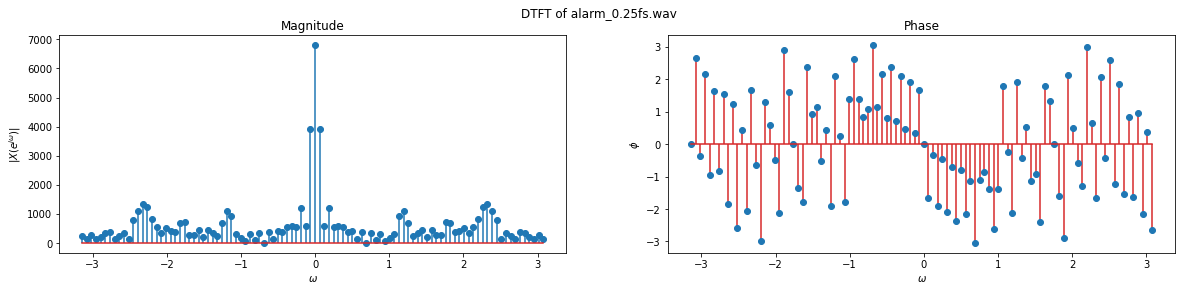

In [97]:
play(new_filename)
analyise_wav_file(new_filename, time_len=0.02, normalise=False)

In [98]:
def convolve(x, h):
    n  =  x.shape[0]
    m = h.shape[0]
    h = np.flip(h)
    pads = np.zeros(m-1)
    x =  np.hstack((pads, x, pads))
    y = np.array([np.dot(x[i:i+m], h) for i in range(n+m-1)])
    return y

def io_plotter(x, h, y):
    plt.rcParams['figure.figsize'] = [10, 4]
    fig, (ax1,ax2) = plt.subplots(1, 2)
    ax1.stem(x)
    ax1.set(xlabel='n', ylabel='x[n]')
    ax2.stem(h)
    ax2.set(xlabel='n', ylabel='h[n]')
    
    plt.figure()
    plt.stem(y)
    plt.xlim(-20, 20)
    plt.xlabel('n')
    plt.ylabel('y[n]')

[1. 1. 1. 1. 1. 1.]


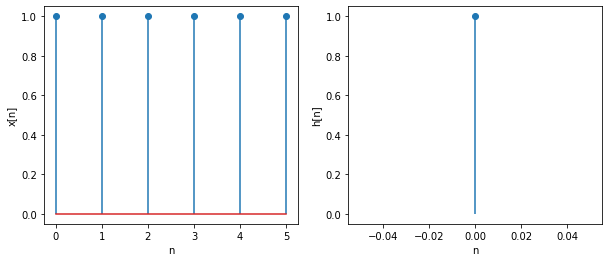

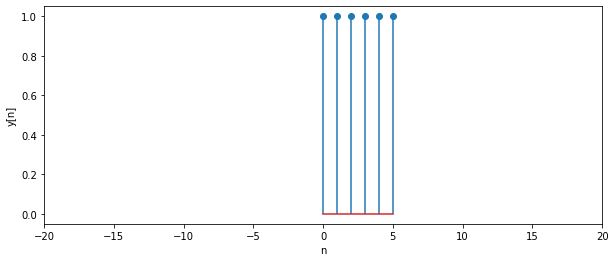

In [99]:
x = np.ones(6)
h = np.array([1])

y = convolve(x, h)
print(y)

io_plotter(x, h, y)

[1. 2. 3. 4. 5. 6. 5. 4. 3. 2. 1.]


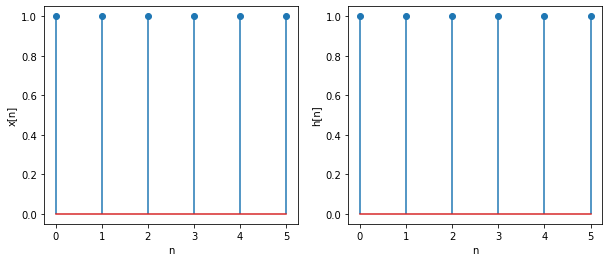

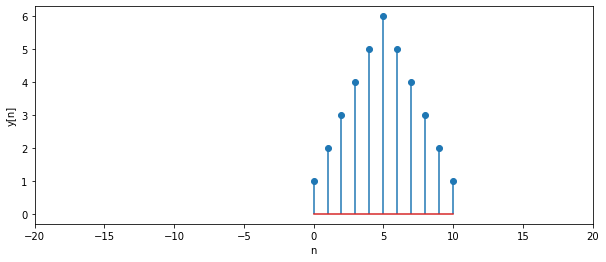

In [100]:
x = np.ones(6)
h = x
y = convolve(x, h)
print(y)

io_plotter(x, h, y)

[ 0.  0.  1.  4. 10. 20. 35. 44. 46. 40. 25.]


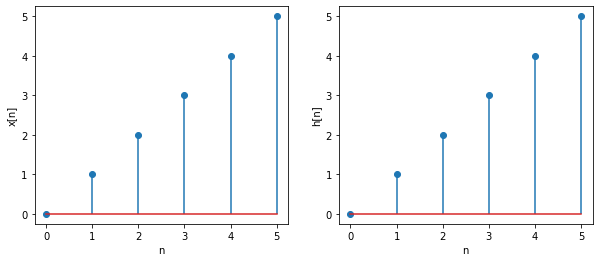

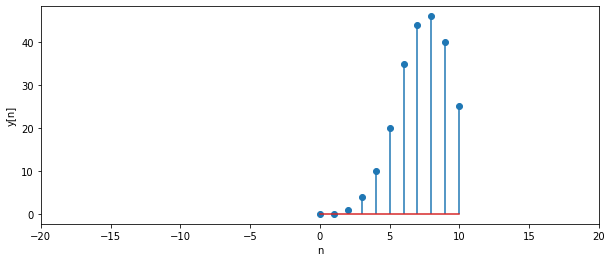

In [101]:
x = np.arange(6)
h = x

y = convolve(x, h)
print(y)

io_plotter(x, h, y)

[ 0.5  0.   0.   0.   0.   0.  -0.5]


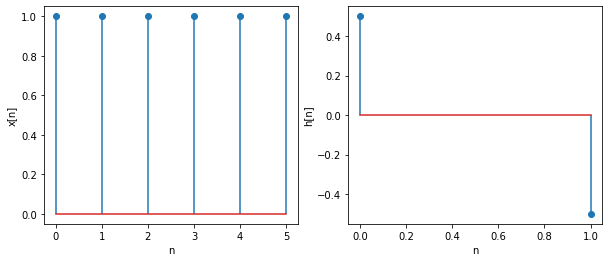

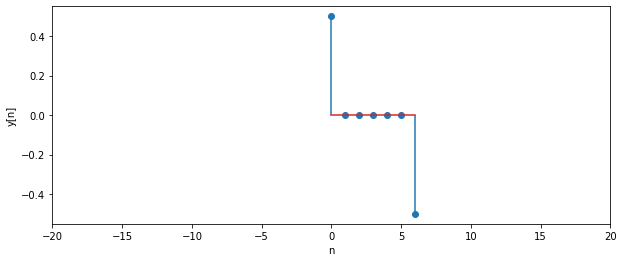

In [102]:
x = np.ones(6)
h = np.array([0.5, -0.5])

y = convolve(x, h)
print(y)

io_plotter(x, h, y)

[ 0.5  0.   0.   0.   0.   0.  -0.5]


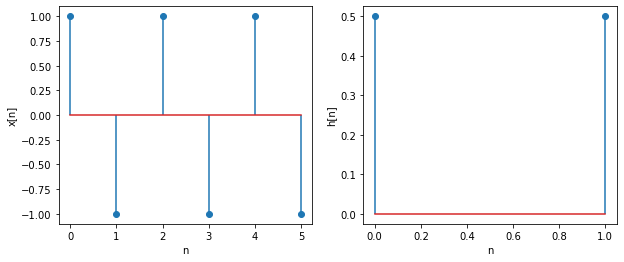

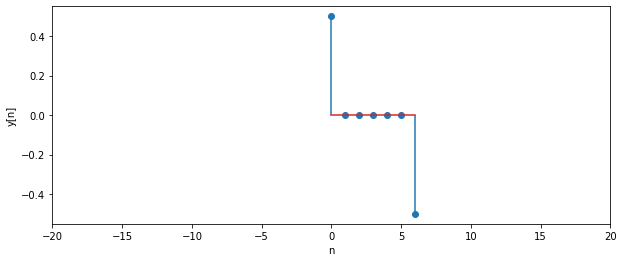

In [103]:
x = np.cos(np.pi*np.arange(6))
h = np.array([0.5, 0.5])

y = convolve(x, h)
print(y)

io_plotter(x, h, y)

In [120]:
def audio_convolve(i, h, normalisation, o, time_len=None):
    x, t, nframes, fr = wavfile_to_nparray(i, time_len=time_len, normalise=normalisation)
    y_file = o
    y_filep = wave.open(y_file, 'wb')
    y_filep.setnchannels(1)
    y_filep.setsampwidth(1)
    y_filep.setframerate(fr)
    
    y = convolve(x, h)
    y = np.clip(y, 0, 255).astype(np.int8)
    
    if normalisation:
        y = (y+1)*(2**7)
    
    y = y.tobytes()
    y_filep.writeframesraw(y)
    y_filep.close()

    return y_file

Channels= 1 , SampleWidth= 1 bytes , Framerate= 11025 Hz , Frames= 5397 
Duration: 0.4895238095238095 s



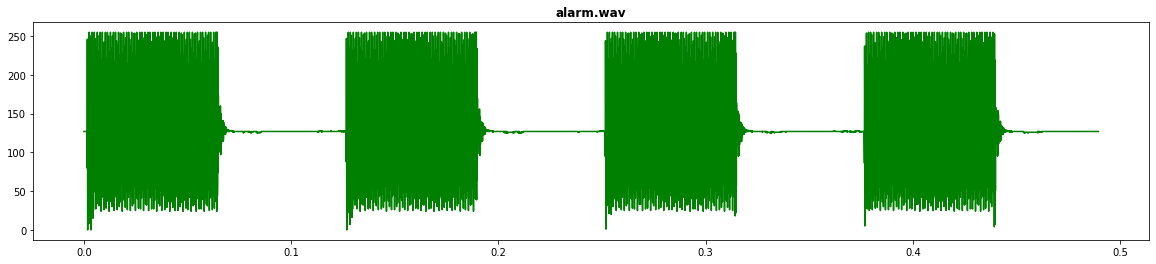

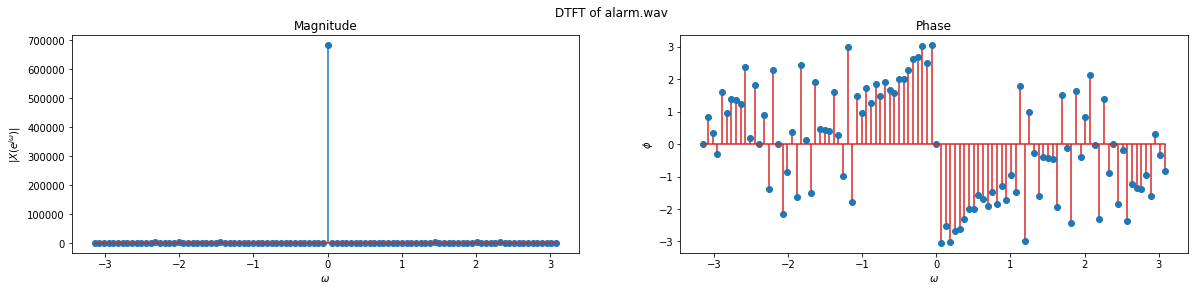

In [130]:
file = 'alarm.wav'
h = np.array([-0.25, 0.50, -0.25])
op = audio_convolve(file, h, normalisation=False, o='1.wav')

play(file)
analyise_wav_file(file, normalise=False)

Channels= 1 , SampleWidth= 1 bytes , Framerate= 11025 Hz , Frames= 5399 
Duration: 0.4897052154195011 s



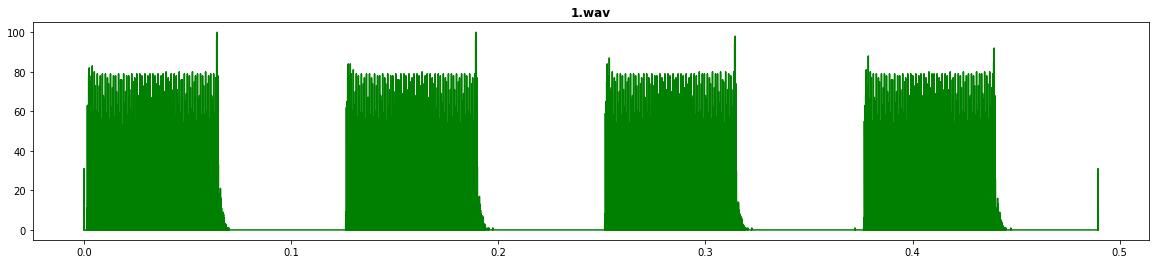

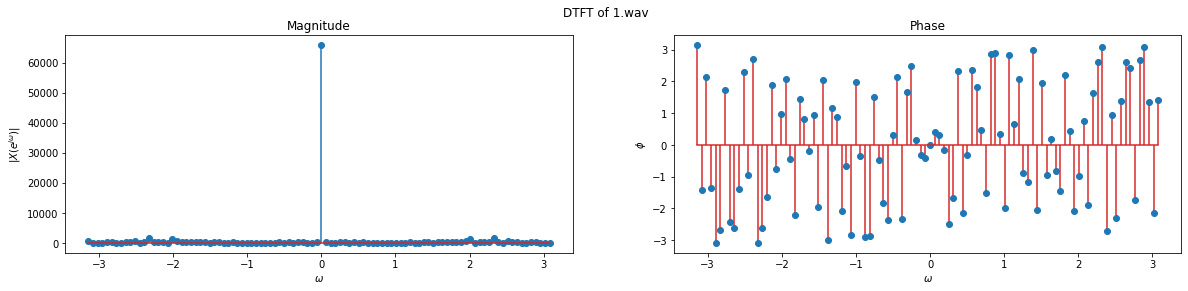

In [131]:
play(op)
analyise_wav_file(op, normalise=False)